In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.layers import Dropout, SpatialDropout1D, TimeDistributed,Flatten, GlobalMaxPool1D, BatchNormalization, multiply
from tensorflow.keras.layers import Embedding
import seaborn as sns
import matplotlib.pyplot as plt

import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv("test.csv")

C:\Users\SOUMYA\AppData\Local\Temp/ipykernel_24600/2114646410.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv("test.csv")


In [3]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
test_data.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [5]:
train_data = train_data.sample(frac=0.1).reset_index(drop=True)
test_data = test_data.sample(frac=0.01).reset_index(drop=True)

In [6]:
train_data.shape, test_data.shape

((40429, 6), (35635, 3))

In [7]:
train_data = train_data.drop(['id','qid1','qid2'],axis=1)
test_data = test_data.drop(['test_id'],axis=1)
train_data.head()

,question1,question2,is_duplicate
0,What type of spices go great with mashed potat...,What are some good spices to add to a mashed p...,1
1,What are some scientific or psychological theo...,What is the scientific reason for homosexuality?,1
2,How can I publish my articles in the newspapers?,How do I publish articles for newspapers?,1
3,How can I become a good songwriter?,How do I become good at songwriting?,1
4,Which are the best Quora answers one must read?,What are some of the best answers on Quora?,1


<AxesSubplot:>

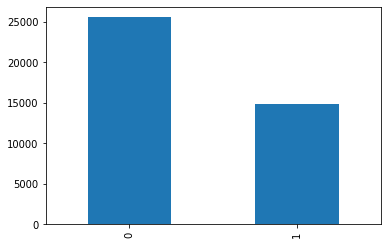

In [8]:
train_data.is_duplicate.value_counts().plot(kind='bar')

In [9]:
train_data[train_data['is_duplicate']==1].shape,train_data[train_data['is_duplicate']==0].shape

((14874, 3), (25555, 3))

In [10]:
is_duplicate = train_data[train_data['is_duplicate']==1]
not_duplicate = train_data[train_data['is_duplicate']==0].sample(14798)

In [11]:
train_data = pd.concat([is_duplicate,not_duplicate])
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data

,question1,question2,is_duplicate
0,Which is the best laptop under Rs 25000?,What is the best laptop to buy in the range of...,1
1,I've been with a girl for a month and she isn'...,I saw a girl everyday in a bus. I knew for sur...,0
2,What are the best two words to describe life?,What is the best word or words to describe a h...,0
3,What countries are socialist?,Are there any socialist countries left?,1
4,What percentage of people with Prader-Wili Syn...,How hard is frc off season?,0
...,...,...,...
29667,"I have $50,000 which I would like to invest an...","I am 18 years old and have Rs. 10,000 in hand....",0
29668,Why do some Hindus add Jesus to their huge lis...,Why did the God only appoint Muhammad as their...,0
29669,"Can We Truly ""Cure"" Cancer?",MyDad has a low sugar level of 68mg/dLHe has s...,0
29670,What if Muslim population is more than 50% in ...,What will happen if muslims population increas...,1


<AxesSubplot:>

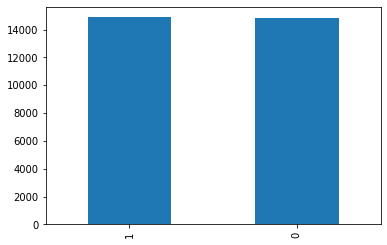

In [12]:
train_data.is_duplicate.value_counts().plot(kind='bar')

In [13]:
#Lemmatize Words

def get_pos_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN

lemmatizer = WordNetLemmatizer()

In [14]:
#cleaning the data now 

regex = [
    r'<[^>]+>', #HTML tags
    r'@(\w+)', # @-mentions
    r"#(\w+)", # hashtags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'[^0-9a-z #+_\\r\\n\\t]', #BAD SYMBOLS
]

REPLACE_URLS = re.compile(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+')
REPLACE_HASH = re.compile(r'#(\w+)')
REPLACE_AT = re.compile(r'@(\w+)')
REPLACE_HTML_TAGS = re.compile(r'<[^>]+>')
REPLACE_DIGITS = re.compile(r'\d+')
#REPLACE_BY = re.compile(r"[/(){}\[\]\|,;.:?\-\'\"$]")
REPLACE_BY = re.compile(r"[^a-z0-9\-]")

STOPWORDS = set(stopwords.words('english'))

#tokens_re = re.compile(r'('+'|'.join(regex)+')', re.VERBOSE | re.IGNORECASE)

# sentences = [] #for Word2Vec model

def clean_text(text):
    #print(text)
    text = text.lower()
    text = REPLACE_HTML_TAGS.sub(' ', text)
    text = REPLACE_URLS.sub('', text)
    text = REPLACE_HASH.sub('', text)
    text = REPLACE_AT.sub('', text)
    text = REPLACE_DIGITS.sub(' ', text)
    text = REPLACE_BY.sub(' ', text)
    
    
    text = " ".join(lemmatizer.lemmatize(word.strip(), get_pos_tag(pos_tag([word.strip()])[0][1])) for word in text.split() if word not in STOPWORDS and len(word)>3)
    
    #sentences.append(text.split())
    return text

In [15]:
train_data.isnull().sum()

question1       0
question2       0
is_duplicate    0
dtype: int64

In [16]:
train_data = train_data.fillna('null')

In [17]:
get_pos_tag(pos_tag(['playing'.strip()])[0][1])

'v'

In [18]:
pos_tag(['word'.strip()])

[('word', 'NN')]

In [19]:
lemmatizer.lemmatize('playing'.strip(), get_pos_tag(pos_tag(['playing'.strip()])[0][1]))

'play'

In [20]:
get_pos_tag(pos_tag(['playing'.strip()])[0][1])

'v'

In [21]:
lemmatizer.lemmatize('playable'.strip(),'v' )

'playable'

In [22]:
train_data['q1'] = train_data['question1'].apply(clean_text)

In [23]:
train_data['q2'] = train_data['question2'].apply(clean_text)

In [24]:
train_data.head()

,question1,question2,is_duplicate,q1,q2
0,Which is the best laptop under Rs 25000?,What is the best laptop to buy in the range of...,1,best laptop,best laptop range
1,I've been with a girl for a month and she isn'...,I saw a girl everyday in a bus. I knew for sur...,0,girl month sure problem anything,girl everyday knew sure eyed suddenly three mo...
2,What are the best two words to describe life?,What is the best word or words to describe a h...,0,best word describe life,best word word describe healthy simple life en...
3,What countries are socialist?,Are there any socialist countries left?,1,country socialist,socialist country left
4,What percentage of people with Prader-Wili Syn...,How hard is frc off season?,0,percentage people prader-wili syndrome also in...,hard season


In [25]:
test_data['q1'] = test_data['question1'].apply(clean_text)
test_data['q2'] = test_data['question2'].apply(clean_text)
test_data.head()

,question1,question2,q1,q2
0,"What does the ""the nature of business"" mean?","What does the phrase ""double whammy""?",nature business mean,phrase double whammy
1,How edge I convince my parents to let me marry...,What is first step in convincing my parents I ...,edge convince parent marry love,first step convincing parent want parent happy...
2,Only students of Tamil Nadu can study in Tamil...,What in the TV show Frequency filmed?,student tamil nadu study tamil nadu agricultural,show frequency film
3,How can I download + from ozee.com?,How she do I download videos from letv.com?,download ozee,download video letv
4,Snore become journey?,What is a good name for a medical company that...,snore become journey,good name medical company sell point product m...


In [26]:
#max len of clean data
max_len_q1 = np.max(train_data["q1"].apply(lambda x: len(x.split())))
max_len_q2 = np.max(train_data["q2"].apply(lambda x: len(x.split())))
max_len_q1, max_len_q2

(25, 90)

In [27]:
MAX_NB_WORDS = 200000

tokenizer = Tokenizer(num_words = MAX_NB_WORDS)

tokenizer.fit_on_texts(list(train_data['q1'].values.astype(str))+list(train_data['q2'].values.astype(str)))

tokenizer

In [28]:
X_train_q1 = tokenizer.texts_to_sequences(train_data['q1'].values.astype(str))
X_train_q1 = pad_sequences(X_train_q1, maxlen = 30, padding = 'post')
X_train_q1

array([[   1,  136,    0, ...,    0,    0,    0],
       [  40,  106, 1163, ...,    0,    0,    0],
       [   1,  135,  698, ...,    0,    0,    0],
       ...,
       [1182,  765,  681, ...,    0,    0,    0],
       [ 296, 1095,    2, ...,    0,    0,    0],
       [ 539, 1675, 1288, ...,    0,    0,    0]])

In [29]:
X_train_q2 = tokenizer.texts_to_sequences(train_data['q2'].values.astype(str))
X_train_q2 = pad_sequences(X_train_q2, maxlen = 30, padding = 'post')
X_train_q2

array([[    1,   136,   768, ...,     0,     0,     0],
       [   40,  1048,  1604, ...,     0,     0,     0],
       [    1,   135,   135, ...,     0,     0,     0],
       ...,
       [17486,  1487,   321, ...,     0,     0,     0],
       [   56,   296,  1095, ...,     0,     0,     0],
       [  411,   539,  6239, ...,     0,     0,     0]])

In [30]:
X_test_q1 = tokenizer.texts_to_sequences(test_data['q1'].ravel())
X_test_q1 = pad_sequences(X_test_q1,maxlen = 30, padding='post')

X_test_q2 = tokenizer.texts_to_sequences(test_data['q2'].astype(str).ravel())
X_test_q2 = pad_sequences(X_test_q2, maxlen = 30, padding='post')

In [31]:
y = train_data['is_duplicate']

In [32]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

17488

### Loading Glove word embedding

In [33]:
embeddings_index = {}
glovefile = open('glove.6B.200d.txt','r',encoding='utf-8')
for line in tqdm(glovefile):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
#     coefs.shape
    embeddings_index[word] = coefs
glovefile.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:20, 19791.55it/s]

Found 400000 word vectors.


In [34]:
#creating embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 200))
for words, index in tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

100%|██████████| 17487/17487 [00:00<00:00, 563951.14it/s]


In [35]:
X_train_q1,X_valid_q1, X_train_q2, X_valid_q2, y_train, y_valid = train_test_split(X_train_q1, X_train_q2, y, test_size=0.20, random_state=12)
print(X_train_q1.shape, X_train_q2.shape, y_train.shape)
print(X_valid_q1.shape, X_valid_q2.shape, y_valid.shape)

(23737, 30) (23737, 30) (23737,)
(5935, 30) (5935, 30) (5935,)


In [36]:
# Model for Q1

model_q1 = Sequential([Embedding(input_dim = vocab_size,output_dim = 200,weights = [embedding_matrix],input_length = 30),
                      LSTM(128, activation = 'tanh', return_sequences = True),
                      Dropout(0.2),
                      LSTM(128, return_sequences = True),
                      LSTM(128),
                      Dense(60, activation = 'tanh'),
                      Dense(2, activation = 'sigmoid')])

In [37]:
# Model for Q2

model_q2 = Sequential([Embedding(input_dim = vocab_size,output_dim = 200,weights = [embedding_matrix],input_length = 30),
                      LSTM(128, activation = 'tanh', return_sequences = True),
                      Dropout(0.2),
                      LSTM(128, return_sequences = True),
                      LSTM(128),
                      Dense(60, activation = 'tanh'),
                      Dense(2, activation = 'sigmoid')])

In [38]:
# Merging the output of the two models,i.e, model_q1 and model_q2
mergedOut = multiply([model_q1.output, model_q2.output])

mergedOut = Flatten()(mergedOut)
mergedOut = Dense(100, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(50, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(2, activation = 'sigmoid')(mergedOut)

In [39]:
new_model = tf.keras.Model([model_q1.input, model_q2.input], mergedOut)
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])

In [40]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_1_input (InputLayer)  [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 200)      3497600     embedding_input[0][0]            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 200)      3497600     embedding_1_input[0][0]          
______________________________________________________________________________________________

In [41]:
history = new_model.fit([X_train_q1,X_train_q2],y_train, batch_size = 2000, epochs = 20, validation_data = ([X_valid_q1,X_valid_q2],y_valid))

Epoch 1/20
12/12 [==============================] - 18s 516ms/step - loss: 0.6924 - accuracy: 0.5313 - val_loss: 0.6897 - val_accuracy: 0.5850
Epoch 2/20
12/12 [==============================] - 3s 260ms/step - loss: 0.6857 - accuracy: 0.5812 - val_loss: 0.6856 - val_accuracy: 0.5580
Epoch 3/20
12/12 [==============================] - 3s 262ms/step - loss: 0.6827 - accuracy: 0.5820 - val_loss: 0.6800 - val_accuracy: 0.5909
Epoch 4/20
12/12 [==============================] - 3s 261ms/step - loss: 0.6763 - accuracy: 0.5969 - val_loss: 0.6730 - val_accuracy: 0.5936
Epoch 5/20
12/12 [==============================] - 3s 262ms/step - loss: 0.6677 - accuracy: 0.6112 - val_loss: 0.6551 - val_accuracy: 0.6394
Epoch 6/20
12/12 [==============================] - 3s 263ms/step - loss: 0.6308 - accuracy: 0.6765 - val_loss: 0.6372 - val_accuracy: 0.6516
Epoch 7/20
12/12 [==============================] - 3s 263ms/step - loss: 0.5878 - accuracy: 0.7158 - val_loss: 0.6119 - val_accuracy: 0.6725
Epoch

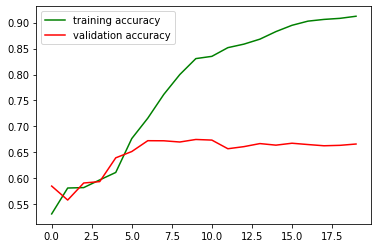

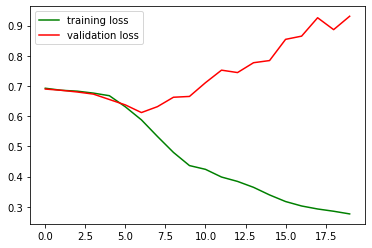

In [42]:
accuracy = history.history["accuracy"]
loss = history.history["loss"]

val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

#plot 
plt.plot(accuracy,'g',label='training accuracy')
plt.plot(val_accuracy, 'r', label='validation accuracy')
plt.legend()
plt.show()


plt.plot(loss,'g',label='training loss')
plt.plot(val_loss, 'r', label='validation loss')
plt.legend()
plt.show()

In [43]:
y_pred = new_model.predict([X_test_q1, X_test_q2])

In [44]:
np.argmax(y_pred[:10], axis=-1)  

array([1, 0, 0, 1, 1, 1, 1, 0, 0, 1], dtype=int64)

In [46]:
import pickle

# serialize model to JSON
model_json = new_model.to_json()
with open("similarity_model.json", "w") as json_file:
    json_file.write(model_json)
    
# saving model
new_model.save('similarity_model.h5')
print("Model saved")

# saving tokenizer
with open('similarity_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('Tokenizer saved')

Model saved
Tokenizer saved
